## 1 Data preparation

### 1.1 Import

In [43]:
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/ECE247'
    !pip install torchinfo
    !pip install livelossplot --quiet

In [52]:
import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
from torchinfo import summary
from livelossplot import PlotLosses

random.seed(12345) 
np.random.seed(12345) 
torch.manual_seed(12345)

print(f'Using python version {sys.version}')
print(f'Using pytorch version {torch.__version__}')

Using python version 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Using pytorch version 1.13.1+cpu


In [45]:
if torch.cuda.is_available():
    device = 0
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print(device, gpu_info)
else:
    device = 'cpu'
    print(device)

device = torch.device(device) 

cpu


### 1.2 Load data

In [46]:
X_train_val = np.load("X_train_valid.npy")
y_train_val = np.load("y_train_valid.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_val = np.load("person_train_valid.npy").flatten()
person_test = np.load("person_test.npy").flatten()

print ('Training/val data shape: {}'.format(X_train_val.shape))
print ('Training/val target shape: {}'.format(y_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/val shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

num_trials, num_channels, num_samples = X_train_val.shape

Training/val data shape: (2115, 22, 1000)
Training/val target shape: (2115,)
Test data shape: (443, 22, 1000)
Test target shape: (443,)
Person train/val shape: (2115,)
Person test shape: (443,)


In [31]:
# Labels: 0-left, 1-right, 2-down, 3-up
y_train_val = (y_train_val - np.min(y_train_val)).astype('int')
y_test = (y_test - np.min(y_test)).astype('int')

In [32]:
# Find the subject data
X_train_val_subs = [X_train_val[(person_train_val == i)] for i in range(9)]
y_train_val_subs = [y_train_val[(person_train_val == i)] for i in range(9)]
X_test_subs = [X_test[(person_test == i)] for i in range(9)]
y_test_subs = [y_test[(person_test == i)] for i in range(9)]
print([len(sub) for sub in y_train_val_subs])
print([len(sub) for sub in y_test_subs])

[237, 236, 236, 234, 235, 236, 238, 232, 231]
[50, 50, 50, 50, 47, 49, 50, 50, 47]


In [33]:
# Move data to device
X_train_val_tensor = torch.FloatTensor(X_train_val).to(device)
y_train_val_tensor = torch.LongTensor(y_train_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

X_train_val_s1_tensor = torch.FloatTensor(X_train_val_subs[0]).to(device)
y_train_val_s1_tensor = torch.LongTensor(y_train_val_subs[0]).to(device)
X_test_s1_tensor = torch.FloatTensor(X_test_subs[0]).to(device)
y_test_s1_tensor = torch.LongTensor(X_test_subs[0]).to(device)

### 1.3 Dataset and loaders

In [73]:
class EEGDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        X, y = self.dataset[index]
        X = X.view(1, 22, -1)
        if self.transform:
            X = self.transform(X)
        return X, y

In [70]:
def create_loaders(train_val_data, test_data, batch_size=64, val_per=0.1, transform=None):
    train_val_len = len(train_val_data)
    val_len = int(train_val_len * val_per)
    train_data, val_data = random_split(train_val_data, [train_val_len - val_len, val_len])

    train_set = EEGDataset(train_data, transform=transform)
    val_set = EEGDataset(val_data, transform=transform)
    test_set = EEGDataset(test_data, transform=transform)

    dataloaders = {
        'train': DataLoader(train_set, batch_size, shuffle=True),
        'val': DataLoader(val_set, batch_size, shuffle=False),
        'test': DataLoader(test_set, batch_size, shuffle=False),
    }

    return dataloaders

### 1.4 Pre-processing

In [83]:
class CropTransform:
    def __init__(self, length):
        self.length = length

    def __call__(self, x):
        return transforms.functional.crop(x, 0, 0, 22, self.length)
    
    def __repr__(self):
        return f'self.__class__.__name__{self.length}'


In [78]:
def filter_data(data, fs, order, lowcut, highcut):

    filtered_data = np.zeros_like(data)
    fn = 0.5 * fs  # Nyquist frequency
    low = lowcut / fn
    high = highcut / fn

    for n in np.arange(data.shape[0]):
        single_instance = data[n, :, :]

        for channel in np.arange(single_instance.shape[0]):
            X = single_instance[channel, :]
            b, a = signal.butter(order, [low, high], btype='band')
            y = signal.lfilter(b, a, X)
            filtered_data[n, channel, :] = y

    return filtered_data

In [56]:
def smooth_data(data, ws):
    kern = signal.hanning(ws)[None, None, :]
    kern /= kern.sum()
    return signal.convolve(data, kern, mode='same')


def cwt_data(data, dt, wt_type, scales):
    wav = pywt.ContinuousWavelet(wt_type)
    coefs, freqs = pywt.cwt(data, scales, wav, sampling_period=0.01, method='fft')
    return np.array(coefs[0], dtype=np.float)

In [84]:
transform = transforms.Compose([
    transforms.Normalize(mean=0, std=1, inplace=True),
    transforms.GaussianBlur(kernel_size=(1, 25), sigma=1),
    CropTransform(length=600)
    # transforms.RandomErasing(p=.99, scale=(.02,.08), ratio=(.025,.026), value=0),
    
])

In [81]:
batch_size = 64
train_val_data = TensorDataset(X_train_val_tensor, y_train_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
loaders = create_loaders(train_val_data, test_data, batch_size, transform=transform)

train_val_data_s1 = TensorDataset(X_train_val_s1_tensor, y_train_val_s1_tensor)
test_data_s1 = TensorDataset(X_test_s1_tensor, y_test_s1_tensor)
loaders_s1 = create_loaders(train_val_data_s1, test_data_s1, batch_size, transform=transform)

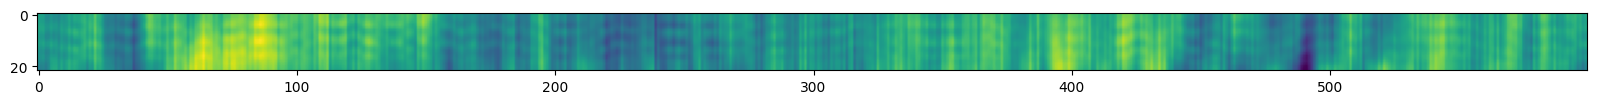

In [82]:
# Visualisation
dataiter = iter(loaders['train'])
images, labels = next(dataiter)
plt.figure(figsize=(20,10))
plt.imshow(images[0].cpu().numpy().squeeze(0))

## 2 General functions

### 2.1 Training script

In [38]:
def train_model(model, optimizer, loss_fn, num_epochs, dataloaders):
    liveloss = PlotLosses()
    pbar = tqdm.tqdm(
        range(num_epochs), position=0, leave=True,
        bar_format='{l_bar}{bar:30}{r_bar}',
    )
    logs = {
        'loss': [], 'acc': [],
        'val_loss': [], 'val_acc': [],
    }
    best_val_loss = float('inf')
    
    for epoch in pbar:
        # Training/Validation Phase
        for isTrain in [True, False]:
            # Init 
            total_loss = 0
            total_trials = 0
            correct_trials = 0

            model.train() if isTrain else model.eval()
            loader = dataloaders['train' if isTrain else 'val']

            for batch_idx, [inputs, labels] in enumerate(loader):
                optimizer.zero_grad()
                with torch.set_grad_enabled(isTrain):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    if isTrain:
                        loss.backward()
                        optimizer.step()
                        
                    total_loss += loss.item()
                    _, predicted = outputs.max(axis=1)
                    total_trials += len(labels)
                    correct_trials += predicted.eq(labels).sum().item()

            cur_loss = total_loss / batch_idx
            cur_acc = correct_trials / total_trials

            if isTrain:
                logs['loss'].append(cur_loss)
                logs['acc'].append(cur_acc)
                liveloss.update
            else:
                if cur_loss < best_val_loss:
                    best_val_loss = cur_loss
                    torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pt')
                logs['val_loss'].append(cur_loss)
                logs['val_acc'].append(cur_acc)

        liveloss.update({k: v[-1] for k, v in logs.items()})
        liveloss.send()
        pbar.set_postfix({'train_acc': logs['acc'][-1], 'val_acc': logs['val_acc'][-1]})
        
    return logs
            

### 2.2 Testing script

In [39]:
def test_model(model, loss_fn, dataloaders):
    total_loss = 0
    total_trials = 0
    correct_trials = 0
    logs = {'test_loss': [], 'test_acc': []}
    loader = dataloaders['test']
    
    model.eval()
    with torch.no_grad():
        for batch_idx, [inputs, labels] in enumerate(loader):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(axis=1)
            total_trials += len(labels)
            correct_trials += predicted.eq(labels).sum().item()

        cur_loss = total_loss / batch_idx
        cur_acc = correct_trials / total_trials
        logs['test_loss'].append(cur_loss)
        logs['test_acc'].append(cur_acc)

    return logs

## 3 Models

### 3.1 Shallow ConvNet (Baseline)

In [40]:
class ShallowConvNet1(nn.Module):
  def __init__(self, num_classes=4):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 40, (1, 25))
      self.conv2 = nn.Conv2d(40, 40, (22, 1))
      self.avgpool = nn.AvgPool2d((1, 75), stride=(1, 15))    
      self.fc1 = nn.LazyLinear(num_classes)

  def forward(self, x):
    x = x.view(-1, 1, 22, 1000)
    x = F.elu(self.conv1(x))
    x = F.elu(self.conv2(x))
    x = torch.square(x)
    x = self.avgpool(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = F.softmax(x, dim=1)
    return x

In [41]:
input_size = (batch_size, 1, num_channels, num_samples)
print(summary(ShallowConvNet1(), input_size=input_size))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowConvNet1                          [64, 4]                   --
├─Conv2d: 1-1                            [64, 40, 22, 976]         1,040
├─Conv2d: 1-2                            [64, 40, 1, 976]          35,240
├─AvgPool2d: 1-3                         [64, 40, 1, 61]           --
├─Linear: 1-4                            [64, 4]                   9,764
Total params: 46,044
Trainable params: 46,044
Non-trainable params: 0
Total mult-adds (G): 3.63
Input size (MB): 5.63
Forward/backward pass size (MB): 459.74
Params size (MB): 0.18
Estimated Total Size (MB): 465.55


In [17]:
class ShallowConvNet2(nn.Module):
  def __init__(self, num_classes=4):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 40, (1, 25), stride=1)
    self.fc1 = nn.Linear(880, 40)
    self.avgpool = nn.AvgPool1d(75, stride=15)
    self.fc2 = nn.Linear(2440, num_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000) B,C,H,W
    x = self.conv1(x) # (B, 40, 22, 976)
    # x = F.elu(x)
    x = x.permute(0, 3, 1, 2) # (B, 976, 22, 490)
    x = x.view(-1, 976, 880) 
    x = self.fc1(x) # (-1, 976, 40)
    # x = F.elu(x)
    x = torch.square(x) 
    x = x.permute(0, 2, 1) # (-1, 40, 976)
    x = self.avgpool(x) # (-1, 40, 61)
    x = torch.log(x) 
    x = x.reshape(-1, 40*61)
    x = self.fc2(x)
    x = self.softmax(x)

    return x 

In [18]:
input_size = (batch_size, 1, num_channels, num_samples)
print(summary(ShallowConvNet2(), input_size=input_size))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowConvNet2                          [64, 4]                   --
├─Conv2d: 1-1                            [64, 40, 22, 976]         1,040
├─Linear: 1-2                            [64, 976, 40]             35,240
├─AvgPool1d: 1-3                         [64, 40, 61]              --
├─Linear: 1-4                            [64, 4]                   9,764
├─Softmax: 1-5                           [64, 4]                   --
Total params: 46,044
Trainable params: 46,044
Non-trainable params: 0
Total mult-adds (G): 1.43
Input size (MB): 5.63
Forward/backward pass size (MB): 459.74
Params size (MB): 0.18
Estimated Total Size (MB): 465.55


### 3.2 Deep ConvNet

In [ ]:
class DeepConvNet(nn.Module):
  def __init__(self, n_temporal_filters=40, n_spatial_filters=40, num_classes=4):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 25, (1, 10))
      self.conv2 = nn.Conv2d(25, 25, (22, 1))
      self.maxpool1 = nn.MaxPool2d((1, 3), stride=3)
      self.conv3 = nn.Conv2d(25, 50, (1, 10))
      self.maxpool2 = nn.MaxPool2d((1, 3), stride=3)
      self.conv4 = nn.Conv2d(50, 100, (1, 10))
      self.maxpool3 = nn.MaxPool2d((1, 3), stride=3)
      self.conv5 = nn.Conv2d(100, 200, (1, 10))
      self.maxpool4 = nn.MaxPool2d((1, 3), stride=3)
      self.dense = nn.LazyLinear(num_classes)

  def forward(self, x):
    x = F.elu(self.conv1(x))
    x = F.elu(self.conv2(x))
    x = self.maxpool1(x)
    x = F.elu(self.conv3(x))
    x = self.maxpool2(x)
    x = F.elu(self.conv4(x))
    x = self.maxpool3(x)
    x = F.elu(self.conv5(x))
    x = self.maxpool4(x)
    x = x.view(x.shape[0], -1)
    x = self.dense(x)
    return x

In [ ]:
input_size = (batch_size, 1, num_channels, num_samples)
print(summary(DeepConvNet(), input_size=input_size))

## 4 Evaluation

### 4.1 Shallow ConvNet

In [42]:
lr = 1e-4
decay = 0.1
num_epochs = 150
model = ShallowConvNet2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

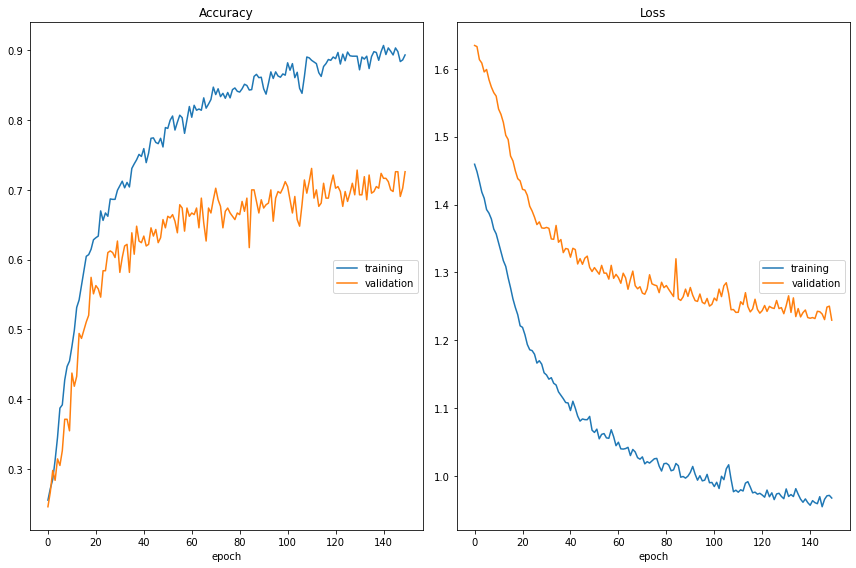

100%|██████████████████████████████| 150/150 [02:11<00:00,  1.14it/s, train_acc=0.893, val_acc=0.726]

Accuracy
	training         	 (min:    0.255, max:    0.907, cur:    0.893)
	validation       	 (min:    0.246, max:    0.730, cur:    0.726)
Loss
	training         	 (min:    0.955, max:    1.459, cur:    0.968)
	validation       	 (min:    1.230, max:    1.634, cur:    1.230)


In [23]:
logs = train_model(model, optimizer, loss_fn, num_epochs, loaders)

In [24]:
model.load_state_dict(torch.load(f'best_{model.__class__.__name__}.pt', map_location=torch.device(device)))
test_logs = test_model(model, loss_fn, loaders)

In [ ]:
plt.figure(dpi=100)
plt.plot(logs['loss'], label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(logs['val_loss'], 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

In [ ]:
plt.figure(dpi=100)
plt.plot(logs['acc'], label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(logs['val_acc'], 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')